<a href="https://colab.research.google.com/github/ngcheeyuan/Classification_projects/blob/main/Wine_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"cheeyuanng","key":"70085cb366ad542072c5a36ba0e09e27"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle datasets download -d yasserh/wine-quality-dataset

wine-quality-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv('WineQT.csv')
df.drop(columns = ['Id'] , axis = 'columns' , inplace = True)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
y = df.quality
X = df.drop(['quality'] , axis = 'columns')

## Splitting data before exploration

In [11]:
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size = 0.6, random_state = 42, stratify = y)

In [12]:
X_val , X_test , y_val , y_test = train_test_split(X_val,y_val,
                                                   train_size = 0.5 ,
                                                   random_state = 42,
                                                   stratify = y_val)

In [13]:
y_val.value_counts()  ,y_test.value_counts() , y_train.value_counts()

(5    97
 6    93
 7    28
 4     6
 8     4
 3     1
 Name: quality, dtype: int64, 5    97
 6    92
 7    29
 4     7
 8     3
 3     1
 Name: quality, dtype: int64, 5    289
 6    277
 7     86
 4     20
 8      9
 3      4
 Name: quality, dtype: int64)

## Base model

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
clf1 = LogisticRegression(class_weight = 'balanced' , 
                         max_iter = 10000 , 
                         tol = 0.0001,
                         solver ='liblinear')

In [16]:
clf1.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, solver='liblinear')

In [17]:
clf1.score(X_train,y_train)

0.5080291970802919

In [18]:
clf1.score(X_val,y_val)

0.5327510917030568

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [20]:
predictions = clf1.predict(X_val)

In [21]:
cm = confusion_matrix(y_true = y_val,
                      y_pred = predictions)

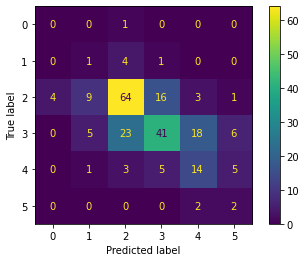

In [22]:
ConfusionMatrixDisplay(cm).plot()

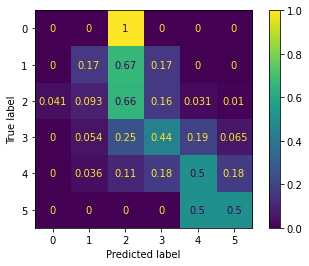

In [23]:
cm_2 = confusion_matrix(y_true = y_val,
                        y_pred = predictions,normalize = 'true')
ConfusionMatrixDisplay(cm_2).plot()

In [24]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.compose import make_column_selector , make_column_transformer

In [25]:
ct = make_column_transformer((RobustScaler(),
                              make_column_selector(dtype_include = np.number)))

In [72]:
pipe = Pipeline([('column_transformer',ct),
                 ('clf',VotingClassifier(estimators = [('lr', clf1),
                                                       ('rf', RandomForestClassifier())]
                                         )
                 )
                 ])

In [73]:
param_grid = {}
param_grid['clf__rf__n_estimators'] = [10,20,50]
gs = GridSearchCV(estimator = pipe , 
                  param_grid = param_grid,
                  cv = 2)

In [74]:
gs.fit(X = X_train,
       y = y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('robustscaler',
                                                                         RobustScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f97f71ef210>)])),
                                       ('poly_features', PolynomialFeatures()),
                                       ('clf',
                                        VotingClassifier(estimators=[('lr',
                                                                      LogisticRegression(class_weight='balanced',
                                                                                         max_iter=10000,
                                                                                         solver='liblinear')),
                                              

In [75]:
gs.score(X_val,y_val) , gs.score(X_train,y_train)

(0.6593886462882096, 0.8233576642335766)

In [30]:
gs.best_params_

{'clf__rf__n_estimators': 50}

## EDA :

In [31]:
df_train = pd.concat([X_train,y_train], axis = 1)
df_val = pd.concat([X_val,y_val], axis = 1)
df_eda = df_val.merge(df_train , how = 'outer')

In [32]:
df_eda.reset_index(drop=True, inplace = True)

In [33]:
df_eda.columns = list(map(lambda x : x.replace(' ' , '_') , df.columns.to_list()))

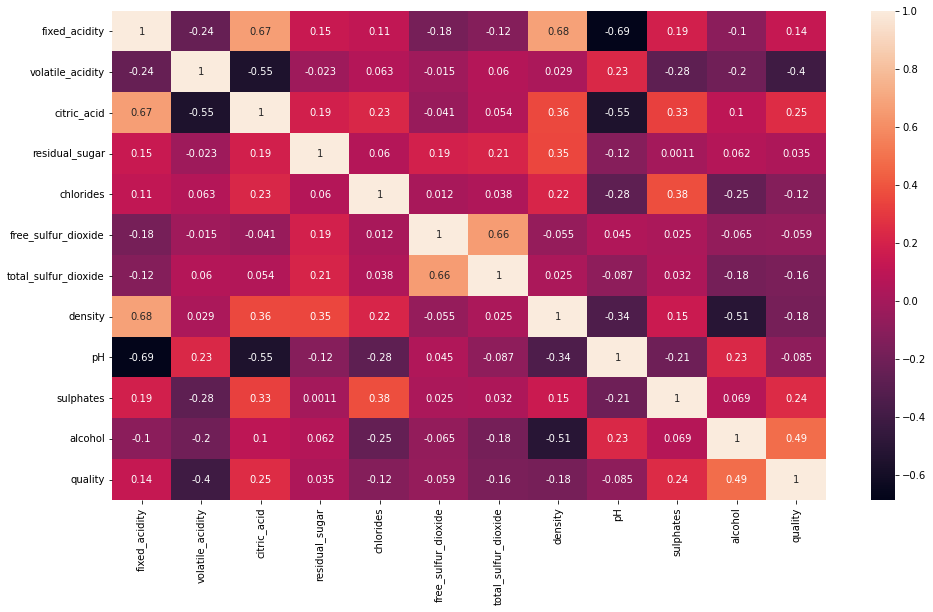

In [34]:
plt.figure(figsize = (16,9))
sns.heatmap(df_eda.corr() , annot = True)

There are some independent variables that has relatively high correlations 
e.g. 
1. free sulfur dioxide vs total sulfur dioxide,
2. pH levels and the different acids

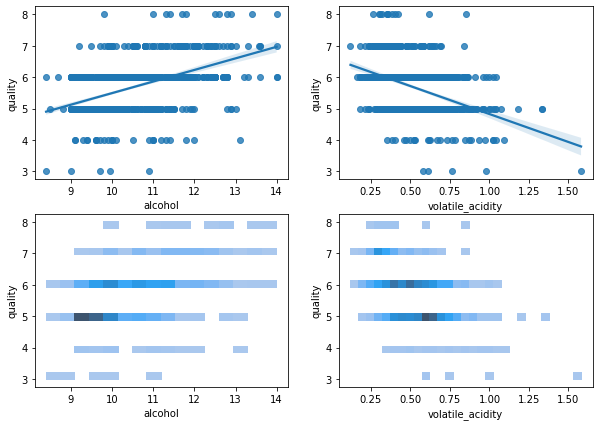

In [35]:
plt.figure(figsize = (10,7))
plt.subplot(2,2,1)
sns.regplot(x = df_eda.alcohol , y = df_eda.quality)
plt.subplot(2,2,3)
sns.histplot(x = df_eda.alcohol , y = df_eda.quality)
plt.subplot(2,2,2)
sns.regplot(x = df_eda.volatile_acidity, y = df_eda.quality)
plt.subplot(2,2,4)
sns.histplot(x = df_eda.volatile_acidity, y = df_eda.quality)

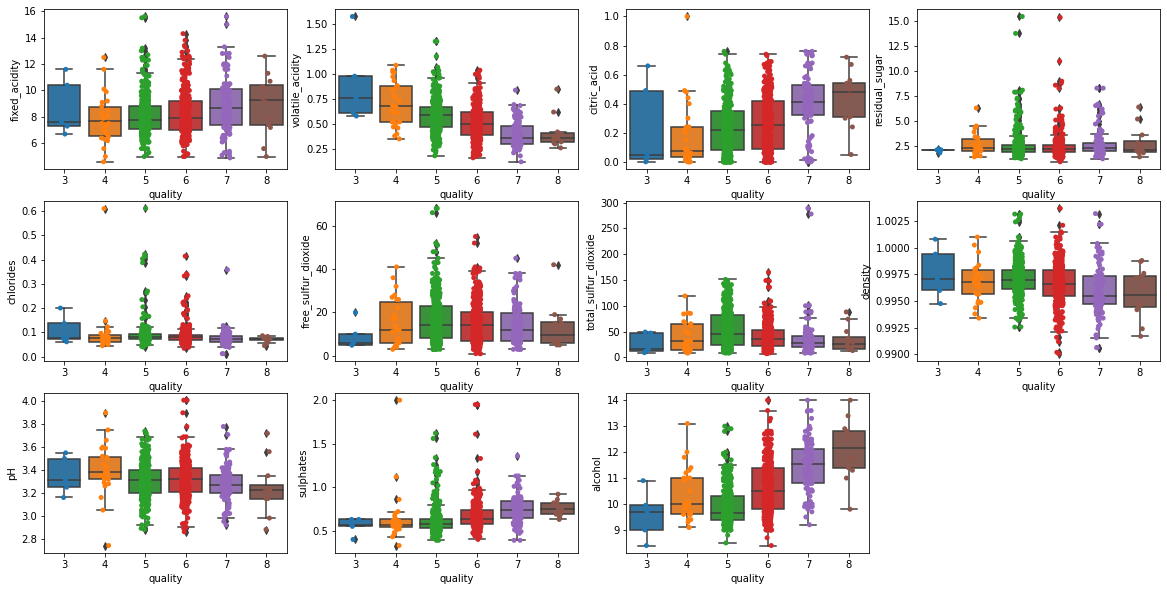

In [39]:
plt.figure(figsize = (20,10))
for index,columns in enumerate(df_eda.drop(columns = ['quality'] , axis = 'columns').columns,1):
  plt.subplot(3,4,index)
  sns.boxplot(x = df_eda.quality , y = df_eda[f'{columns}'])
  sns.stripplot(x = df_eda.quality , y = df_eda[f'{columns}'])

In [40]:
from sklearn.preprocessing import PolynomialFeatures

In [42]:
features = df_eda.drop(columns = ['quality'], axis = 'columns').columns.to_list()

In [49]:
poly = PolynomialFeatures(2)
poly_array = poly.fit_transform(df_eda[features])

In [58]:
df_poly = pd.DataFrame(data = poly_array , columns = poly.get_feature_names_out()).drop(columns = ['1'], axis = 'columns')

In [61]:
df_poly['quality'] = df_eda['quality']

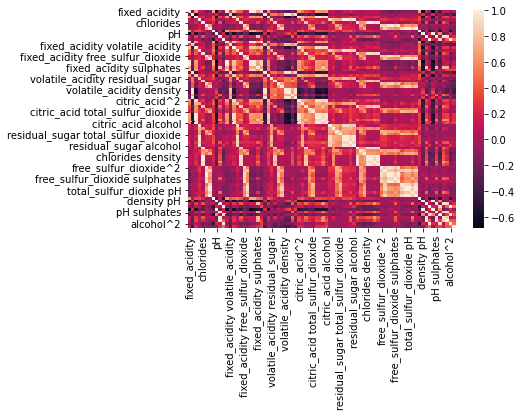

In [64]:
sns.heatmap(df_poly.corr())

In [67]:
df_poly.corr()['quality'].sort_values()

volatile_acidity density         -0.405740
volatile_acidity                 -0.404965
volatile_acidity pH              -0.396380
volatile_acidity^2               -0.376101
fixed_acidity volatile_acidity   -0.321692
                                    ...   
sulphates alcohol                 0.412184
alcohol^2                         0.483594
alcohol                           0.486052
density alcohol                   0.487361
quality                           1.000000
Name: quality, Length: 78, dtype: float64